In [2]:
import pandas as pd

# Read the CSV file into a pandas DataFrame
df = pd.read_csv('../01_preprocess/preprocessed2.csv')
# Calculate the percentile brackets
df['percentile bracket'] = pd.qcut(df['time'], q=10, labels=False, duplicates='drop') + 1

df.drop(['bin_name','cycle', 'instr', 'LLC_miss','CPU','L1_miss', 'br_miss', 'scale', 'counted_final_key_count', 'GHz', 'time'], axis=1, inplace=True)
df.head()

,config_name,const_basicHintCount,const_enableBasicHead,const_enableDense,const_enableDense2,const_enableDensifySplit,const_enableHash,const_enableHashAdapt,const_enableHeadNode,const_enablePrefix,...,nodeCount_Leaf,nodeCount_Inner,nodeCount_Dense,nodeCount_Hash,nodeCount_Head4,nodeCount_Head8,nodeCount_Dense2,task,IPC,percentile bracket
0,hash,16,1,0,0,0,1,0,0,1,...,0,846,0,121433,0,0,0,392.291,0.877,5
1,hash,16,1,0,0,0,1,0,0,1,...,0,846,0,121433,0,0,0,194.439,1.059,4
2,dense3,16,1,1,0,1,0,0,0,1,...,38703,270,0,0,0,0,0,481.293,0.582,3
3,dense3,16,1,1,0,1,0,0,0,1,...,38703,270,0,0,0,0,0,500.832,0.431,8
4,hints,16,1,0,0,0,0,0,0,1,...,27850,742,0,0,0,0,0,505.257,0.532,6


In [4]:
# Identify non-numeric columns
non_numeric_columns = df.select_dtypes(['object']).columns

print("Number of columns:", df.shape[1])

# Apply one-hot encoding to non-numeric columns
df = pd.get_dummies(df, columns=non_numeric_columns)

print("Number of columns after one-hot:", df.shape[1])

Number of columns: 37
Number of columns after one-hot: 42


In [5]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df.drop('percentile bracket', axis=1), df['percentile bracket'], test_size=0.2, random_state=42)

# Create a decision tree classifier
clf = DecisionTreeClassifier()

# Fit the classifier to the training data
clf.fit(X_train, y_train)

# Predict the percentile brackets for the test data
y_pred = clf.predict(X_test)

# Evaluate the performance of the model
accuracy = accuracy_score(y_test, y_pred)
accuracy


0.970494417862839

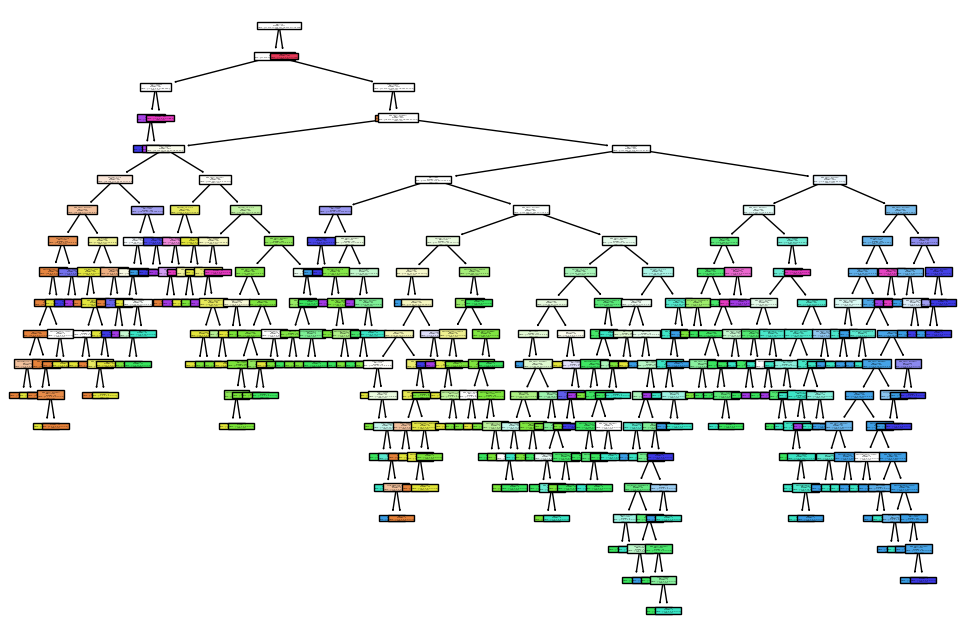

In [7]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

# Convert percentile bracket to strings
df['percentile bracket'] = df['percentile bracket'].astype(str)+"0%"

# Plot the decision tree
plt.figure(figsize=(12, 8))
plot_tree(clf, feature_names=df.drop('percentile bracket', axis=1).columns, class_names=df['percentile bracket'].unique(), filled=True)
plt.show()


In [8]:
from sklearn import tree
text_representation = tree.export_text(clf)
print(text_representation)

|--- feature_31 <= 966.08
|   |--- feature_32 <= 0.50
|   |   |--- feature_31 <= 509.07
|   |   |   |--- feature_31 <= 419.76
|   |   |   |   |--- class: 7
|   |   |   |--- feature_31 >  419.76
|   |   |   |   |--- class: 8
|   |   |--- feature_31 >  509.07
|   |   |   |--- class: 9
|   |--- feature_32 >  0.50
|   |   |--- feature_31 <= 116.21
|   |   |   |--- class: 1
|   |   |--- feature_31 >  116.21
|   |   |   |--- feature_17 <= 3442843.00
|   |   |   |   |--- feature_31 <= 440.63
|   |   |   |   |   |--- feature_37 <= 0.50
|   |   |   |   |   |   |--- feature_17 <= 2975670.00
|   |   |   |   |   |   |   |--- feature_39 <= 0.50
|   |   |   |   |   |   |   |   |--- feature_27 <= 63454.50
|   |   |   |   |   |   |   |   |   |--- feature_31 <= 439.39
|   |   |   |   |   |   |   |   |   |   |--- feature_19 <= 0.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 2
|   |   |   |   |   |   |   |   |   |   |--- feature_19 >  0.50
|   |   |   |   |   |   |   |   |